In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os.path

index_list_1 = [
    "loadtest-webrtc-preliminary-2p-t3medium-final",
    "loadtest-webrtc-preliminary-3p-t3medium-final",
    "loadtest-webrtc-preliminary-5p-t3medium-final",
    "loadtest-webrtc-preliminary-6p-t3medium-final",
    "loadtest-webrtc-preliminary-7p-t3medium-final",
    "loadtest-webrtc-preliminary-8p-t3medium-final",
    "loadtest-webrtc-preliminary-10p-t3medium-final",
    "loadtest-webrtc-preliminary-3p-10s-t3medium-final",
    "loadtest-webrtc-preliminary-3p-40s-t3medium-final",
    "loadtest-webrtc-preliminary-2p-c5xlarge-final",
    "loadtest-webrtc-preliminary-3p-c5xlarge-final",
    "loadtest-webrtc-preliminary-5p-c5xlarge-final",
    "loadtest-webrtc-preliminary-6p-c5xlarge-final",
    "loadtest-webrtc-preliminary-7p-c5xlarge-final",
    "loadtest-webrtc-preliminary-8p-c5xlarge-final",
    "loadtest-webrtc-preliminary-10p-c5xlarge-final",
    "loadtest-webrtc-preliminary-3p-10s-c5xlarge-final",
    "loadtest-webrtc-preliminary-3p-40s-c5xlarge-final",
]

index_list_2 = [
    "loadtest-webrtc-preliminary-2p-t3medium-final-2",
    "loadtest-webrtc-preliminary-3p-t3medium-final-2",
    "loadtest-webrtc-preliminary-5p-t3medium-final-2",
    "loadtest-webrtc-preliminary-6p-t3medium-final-2",
    "loadtest-webrtc-preliminary-7p-t3medium-final-2",
    "loadtest-webrtc-preliminary-8p-t3medium-final-2",
    "loadtest-webrtc-preliminary-10p-t3medium-final-2",
    "loadtest-webrtc-preliminary-3p-10s-t3medium-final-2",
    "loadtest-webrtc-preliminary-3p-40s-t3medium-final-2",
    "loadtest-webrtc-preliminary-2p-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-3p-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-5p-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-6p-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-7p-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-8p-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-10p-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-3p-10s-c5xlarge-final-2",
    "loadtest-webrtc-preliminary-3p-40s-c5xlarge-final-2",
]

index_list_3 = [
    "loadtest-webrtc-preliminary-2p-t3medium-final-3",
    "loadtest-webrtc-preliminary-3p-t3medium-final-3",
    "loadtest-webrtc-preliminary-5p-t3medium-final-3",
    "loadtest-webrtc-preliminary-6p-t3medium-final-3",
    "loadtest-webrtc-preliminary-7p-t3medium-final-3",
    "loadtest-webrtc-preliminary-8p-t3medium-final-3",
    "loadtest-webrtc-preliminary-10p-t3medium-final-3",
    "loadtest-webrtc-preliminary-3p-10s-t3medium-final-3",
    "loadtest-webrtc-preliminary-3p-40s-t3medium-final-3",
    "loadtest-webrtc-preliminary-2p-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-3p-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-5p-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-6p-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-7p-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-8p-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-10p-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-3p-10s-c5xlarge-final-3",
    "loadtest-webrtc-preliminary-3p-40s-c5xlarge-final-3",
]

index_list = index_list_1 + index_list_2 + index_list_3

node_types = ["browseremulator", "masternode", "medianode"]

seconds_per_fragment = 17


In [6]:
df_list = [pd.read_csv(f"dfs/{x}.csv") if os.path.isfile(f"dfs/{x}.csv") else pd.DataFrame() for x in index_list ]
for df_user in df_list:
    if not df_user.empty:
        df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"])
        df_user["cut_index"] = df_user["cut_index"] * seconds_per_fragment
index_data = []
for i, df_user in enumerate(df_list):
    index = index_list[i]
    splitted = index.split("-")
    publishers = int(splitted[3][:-1])
    subscribers = 0
    subscribers_parsed = splitted[4]
    if subscribers_parsed[-1] == "s":
        subscribers = int(subscribers_parsed[:-1])
    users = publishers + subscribers
    repeat = 1
    possible_repeat = splitted[-1]
    if not "final" in possible_repeat:
        repeat = int(possible_repeat)
        instance_type = splitted[-3]
    else:
        instance_type = splitted[-2]
    instance_type = instance_type[:2] + "." + instance_type[2:]
    index_data.append({"instance_type": instance_type, "publishers": publishers, "subscribers": subscribers, "repeat": repeat, "users": users})


In [43]:
df_videos = pd.read_csv(f"dfs/minio_items.csv")
data = []
for i, df_user in enumerate(df_list):
    index = index_list[i]
    if "t3medium" in index:
        current_index_data = index_data[i]
        publishers = current_index_data["publishers"]
        subscribers = current_index_data["subscribers"]
        max_possible_videos = (publishers - 1) * publishers + subscribers * publishers
        if df_user.empty:
            available = 0
            loss_pct = 100
        else:
            available = df_videos[df_videos["index"] == index].count()["file"]
            loss_pct = 100 * (1 - (available / max_possible_videos))
        data.append([ publishers, subscribers, current_index_data["repeat"], max_possible_videos, available, loss_pct])

df_tmp_t3 = pd.DataFrame(data, columns=["publishers", "subscribers", "repeat", "max possible videos", "available videos", "loss percentage"]).sort_values(by=["publishers", "subscribers"], ascending=[True, True])

with open('tex/available-videos-t3medium.tex', 'w') as f:
    f.write(df_tmp_t3.to_latex(index=False, float_format="%.2f"))
df_tmp_t3


,publishers,subscribers,repeat,max possible videos,available videos,loss percentage
0,2,0,1,2,0,100.000000
9,2,0,2,2,2,0.000000
18,2,0,3,2,2,0.000000
1,3,0,1,6,2,66.666667
10,3,0,2,6,6,0.000000
19,3,0,3,6,4,33.333333
7,3,10,1,36,36,0.000000
16,3,10,2,36,12,66.666667
25,3,10,3,36,24,33.333333
8,3,40,1,126,84,33.333333


In [44]:
data = []
for i, df_user in enumerate(df_list):
    index = index_list[i]
    if "c5xlarge" in index:
        current_index_data = index_data[i]
        publishers = current_index_data["publishers"]
        subscribers = current_index_data["subscribers"]
        max_possible_videos = (publishers - 1) * publishers + subscribers * publishers
        if df_user.empty:
            available = 0
            loss_pct = 100
        else:
            available = df_videos[df_videos["index"] == index].count()["file"]
            loss_pct = 100 * (1 - (available / max_possible_videos))
        data.append([ publishers, subscribers, current_index_data["repeat"], max_possible_videos, available, loss_pct])

df_tmp_c5 = pd.DataFrame(data, columns=["publishers", "subscribers", "repeat", "max possible videos", "available videos", "loss percentage"]).sort_values(by=["publishers", "subscribers"], ascending=[True, True])

with open('tex/available-videos-c5xlarge.tex', 'w') as f:
    f.write(df_tmp_c5.to_latex(index=False, float_format="%.2f"))
df_tmp_c5


,publishers,subscribers,repeat,max possible videos,available videos,loss percentage
0,2,0,1,2,2,0.000000
9,2,0,2,2,2,0.000000
18,2,0,3,2,2,0.000000
1,3,0,1,6,6,0.000000
10,3,0,2,6,6,0.000000
19,3,0,3,6,6,0.000000
7,3,10,1,36,36,0.000000
16,3,10,2,36,36,0.000000
25,3,10,3,36,36,0.000000
8,3,40,1,126,126,0.000000


In [40]:
t3_loss = df_tmp_t3["loss percentage"]
c5_loss = df_tmp_c5["loss percentage"]
data = []

average_t3_loss = t3_loss.mean()
average_c5_loss = c5_loss.mean()
average_t3_loss_std = t3_loss.std()
average_c5_loss_std = c5_loss.std()

data.append(["t3.medium", average_t3_loss, average_t3_loss_std])
data.append(["c5.xlarge", average_c5_loss, average_c5_loss_std])

df_loss = pd.DataFrame(data, columns=["instance type", "mean", "std"])
df_loss

,instance type,mean,std
0,t3.medium,53.327454,34.290817
1,c5.xlarge,2.910053,8.768702


In [24]:
data = []
for i, df_tmp in enumerate(df_list):
    if not df_tmp.empty:
        average = df_tmp["vmaf"].mean()
        median = df_tmp["vmaf"].median()
        min = df_tmp["vmaf"].min()
        max = df_tmp["vmaf"].max()
        std = df_tmp["vmaf"].std()
        data.append([index_list[i], min, max, average, median, std])

pd.DataFrame(data, columns=["index_type", "min", "max", "average", "median", "std"])        

,index_type,min,max,average,median,std
0,loadtest-webrtc-preliminary-3p-t3medium-final,0.728090,0.842853,0.810759,0.809631,0.017125
1,loadtest-webrtc-preliminary-5p-t3medium-final,0.714469,0.844109,0.817979,0.816596,0.019518
2,loadtest-webrtc-preliminary-6p-t3medium-final,0.403827,0.829944,0.735098,0.809541,0.138046
3,loadtest-webrtc-preliminary-7p-t3medium-final,0.511328,0.849075,0.762183,0.808743,0.083124
4,loadtest-webrtc-preliminary-8p-t3medium-final,0.548839,0.833244,0.743479,0.780081,0.077226
5,loadtest-webrtc-preliminary-10p-t3medium-final,0.462881,0.837165,0.748904,0.805714,0.086941
6,loadtest-webrtc-preliminary-3p-10s-t3medium-final,0.746755,0.837652,0.809028,0.809657,0.010119
7,loadtest-webrtc-preliminary-3p-40s-t3medium-final,0.646709,0.840778,0.808742,0.809816,0.014007
8,loadtest-webrtc-preliminary-2p-c5xlarge-final,0.806085,0.814756,0.809666,0.809419,0.001191
9,loadtest-webrtc-preliminary-3p-c5xlarge-final,0.704445,0.814051,0.807028,0.809369,0.013713


In [25]:
data = []
expected_dfs = []
for i, df_tmp in enumerate(df_list):
    if (not df_tmp.empty) and ("10p-t3medium" in index_list[i]):
        expected_dfs.append(df_tmp)
        expected_dfs_indexes = index_list[i]

all_df = pd.concat(expected_dfs)

average = all_df["vmaf"].mean()
median = all_df["vmaf"].median()
min = all_df["vmaf"].min()
max = all_df["vmaf"].max()
std = all_df["vmaf"].std()
data.append([min, max, average, median, std])

pd.DataFrame(data, columns=["min", "max", "average", "median", "std"])       

,min,max,average,median,std
0,0.414454,0.837165,0.669328,0.674244,0.065747


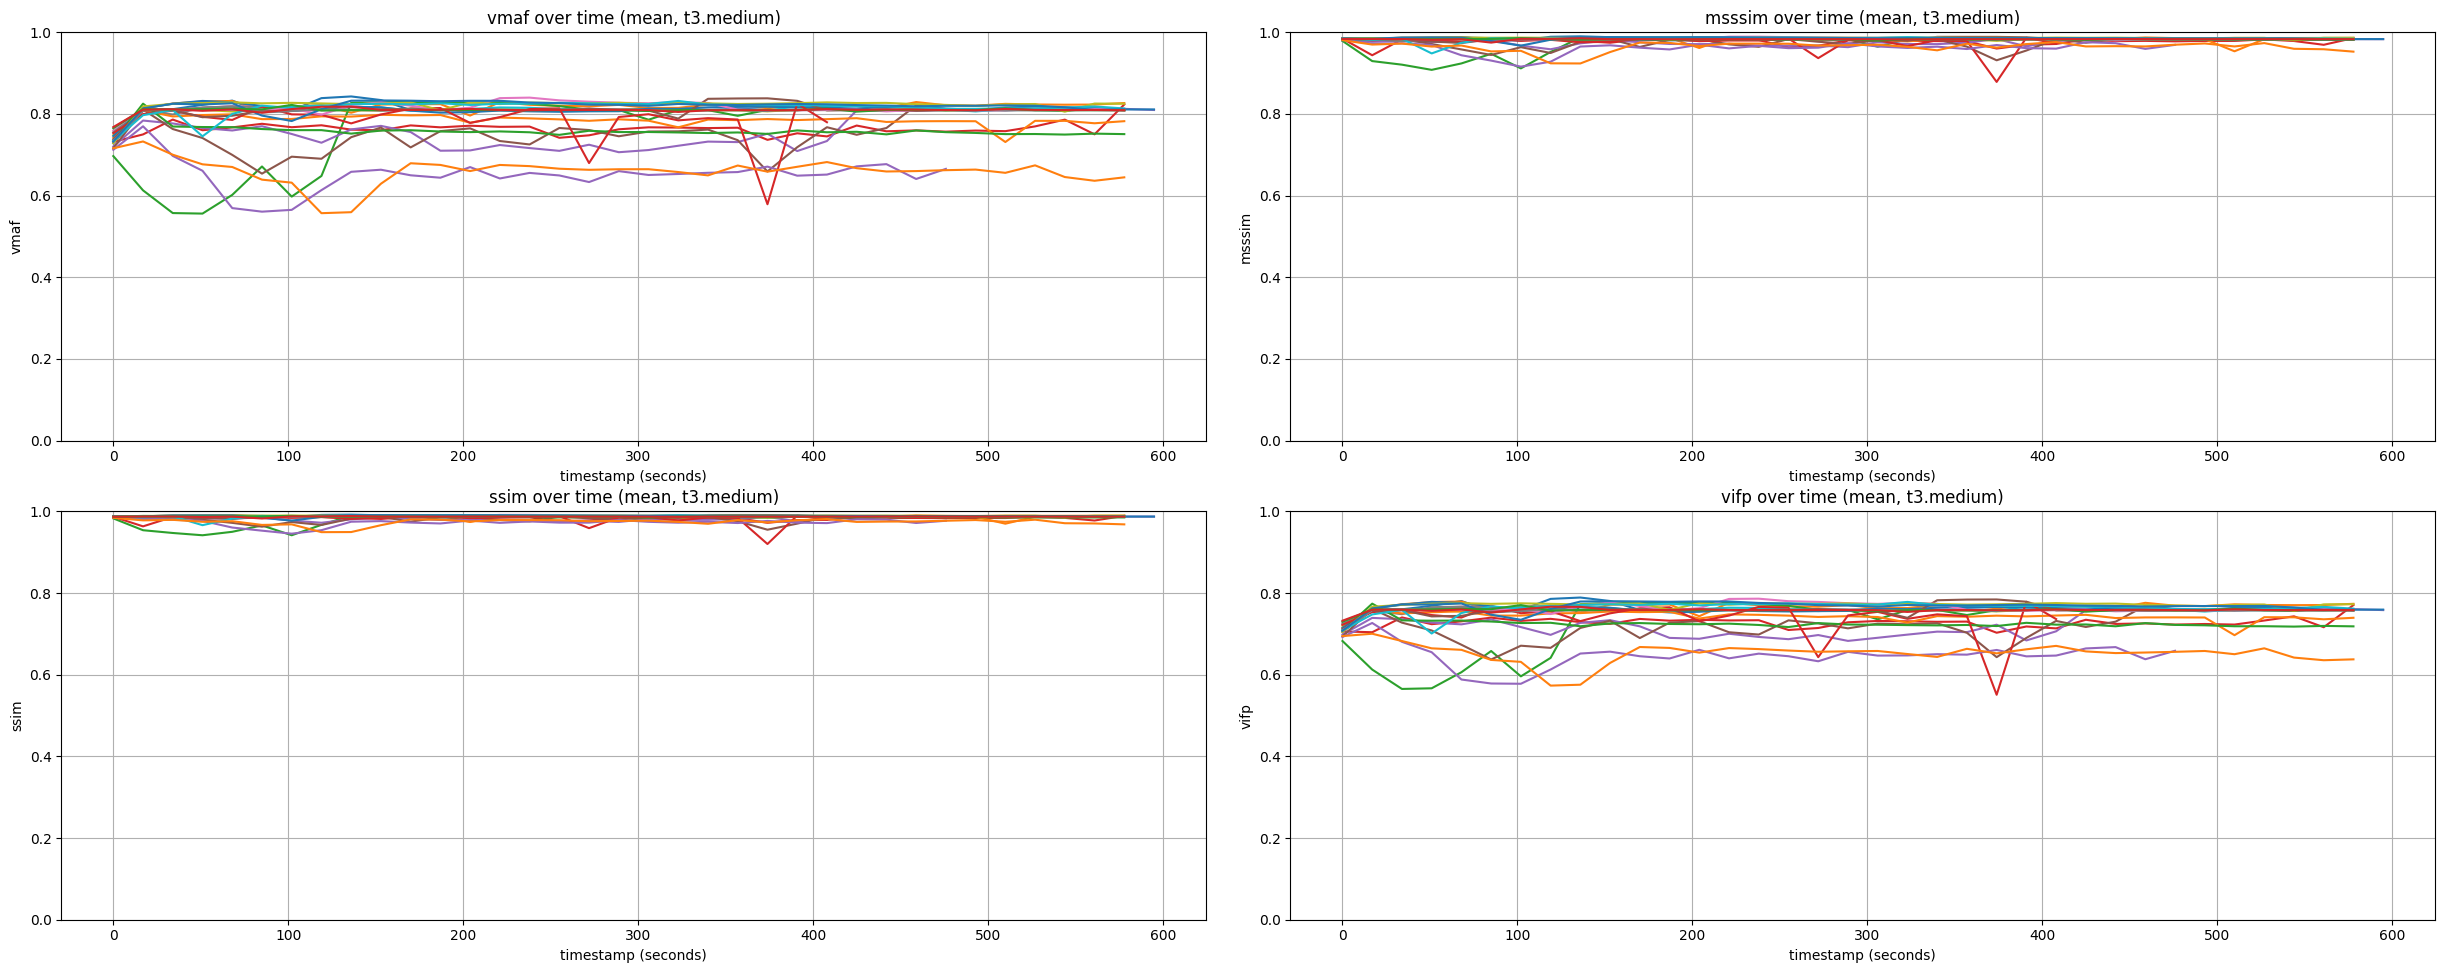

In [26]:
plt.rcParams['figure.figsize'] = [25, 10]
figure, axes = plt.subplots(2, 2)
max = 2
figure.tight_layout(pad=3.0)
metrics = ["vmaf", "msssim", "ssim", "vifp"]
instance_type = "t3"
for idx, metric in enumerate(metrics):
        axe = axes[idx // max][idx % max]
        axe.set_title(metric + " over time (mean, t3.medium)")
        axe.set_xlabel("timestamp (seconds)")
        axe.set_ylabel(metric)
        axe.grid()
        if not "psnr" in metric:
            axe.set_ylim(0, 1)
        for i, df_tmp in enumerate(df_list):
            if not df_tmp.empty:
                if instance_type in index_list[i]:
                    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
                    plot_name = index_list[i][28:]
                    if not df_mean.empty:
                        axe.plot(df_mean.index, df_mean[metric], label=plot_name)
# figlegend = figure.legend()
figure.savefig("images/t3medium_normalized.png")

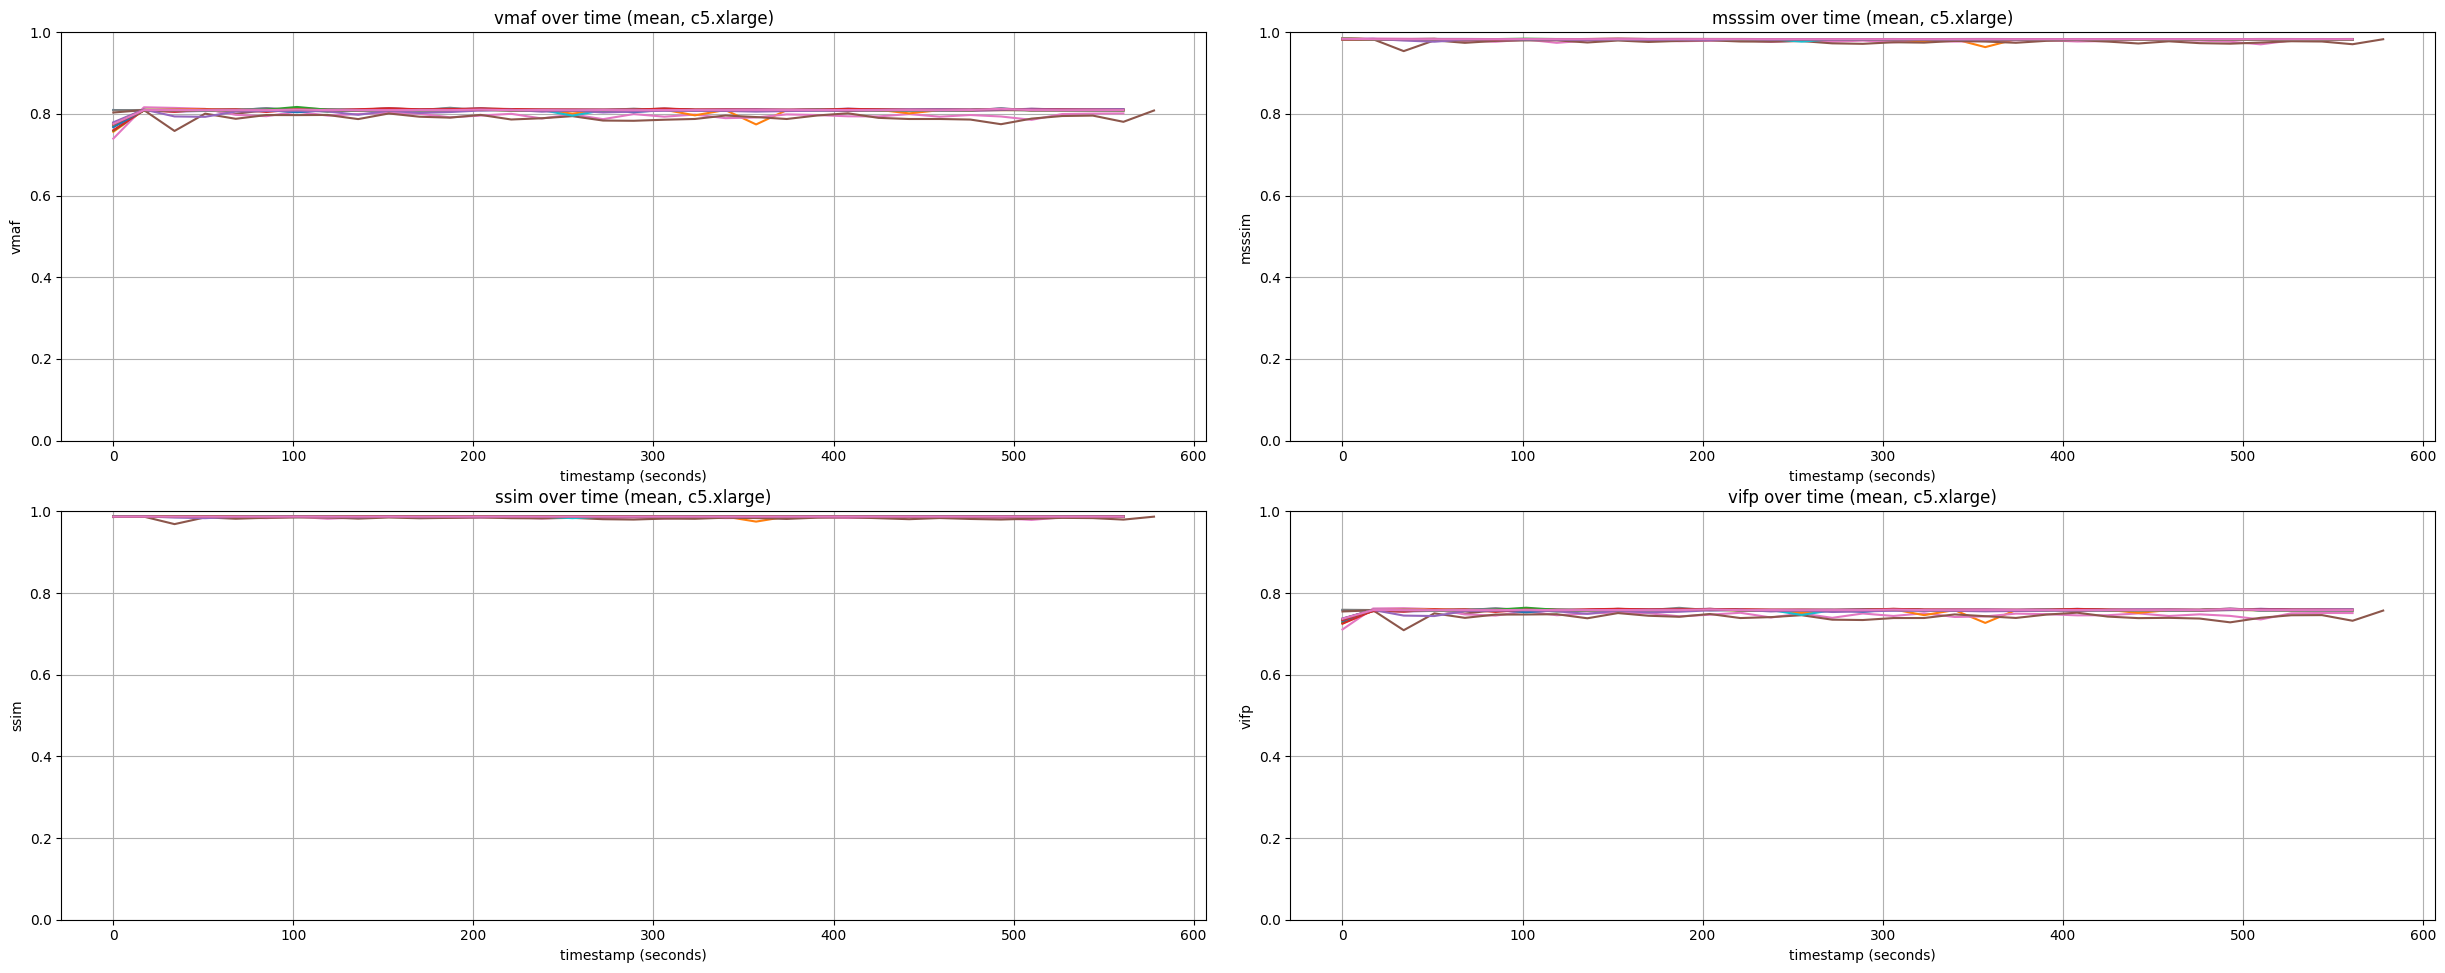

In [27]:
plt.rcParams['figure.figsize'] = [25, 10]
figure, axes = plt.subplots(2, 2)
max = 2
figure.tight_layout(pad=3.0)
metrics = ["vmaf", "msssim", "ssim", "vifp"]
instance_type = "c5"
for idx, metric in enumerate(metrics):
        axe = axes[idx // max][idx % max]
        axe.set_title(metric + " over time (mean, c5.xlarge)")
        axe.set_xlabel("timestamp (seconds)")
        axe.set_ylabel(metric)
        axe.grid()
        if not "psnr" in metric:
            axe.set_ylim(0, 1)
        for i, df_tmp in enumerate(df_list):
            if not df_tmp.empty:
                if instance_type in index_list[i]:
                    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
                    plot_name = index_list[i][28:]
                    if not df_mean.empty:
                        axe.plot(df_mean.index, df_mean[metric], label=plot_name)
# figlegend = figure.legend()
figure.savefig("images/c5xlarge_normalized.png")

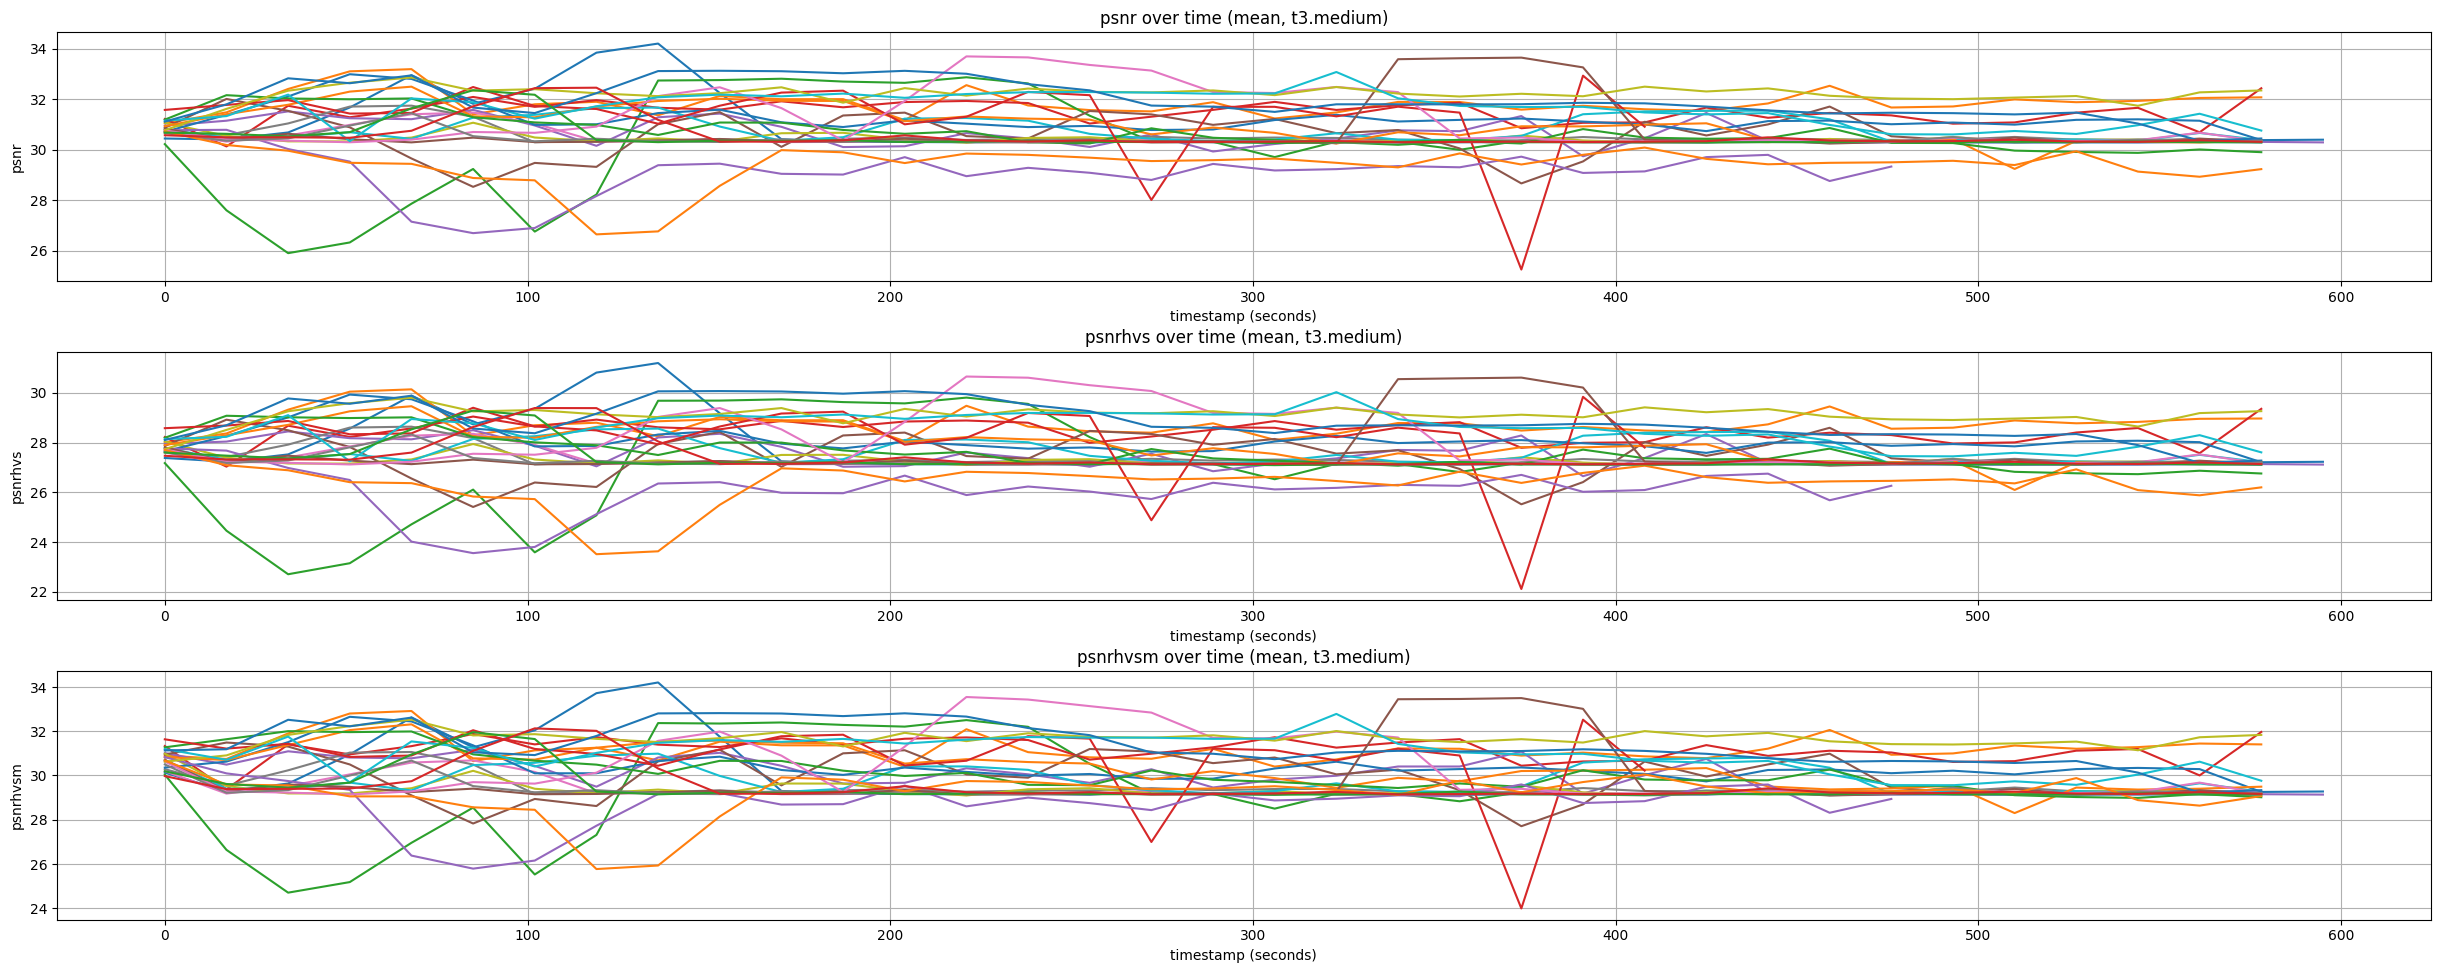

In [28]:
plt.rcParams['figure.figsize'] = [25, 10]
figure, axes = plt.subplots(3, 1)
figure.tight_layout(pad=3.0)
metrics = ["psnr", "psnrhvs", "psnrhvsm"]
max=1
instance_type="t3"
for idx, metric in enumerate(metrics):
        axe = axes[idx // max]
        axe.set_title(metric + " over time (mean, t3.medium)")
        axe.set_xlabel("timestamp (seconds)")
        axe.set_ylabel(metric)
        axe.grid()
        if not "psnr" in metric:
            axe.set_ylim(0, 1)
        for i, df_tmp in enumerate(df_list):
            if not df_tmp.empty:
                if instance_type in index_list[i]:
                    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
                    plot_name = index_list[i][28:]
                    if not df_mean.empty:
                        axe.plot(df_mean.index, df_mean[metric], label=plot_name)
#plt.legend(loc="upper left")
figure.savefig("images/t3medium_psnr.png")

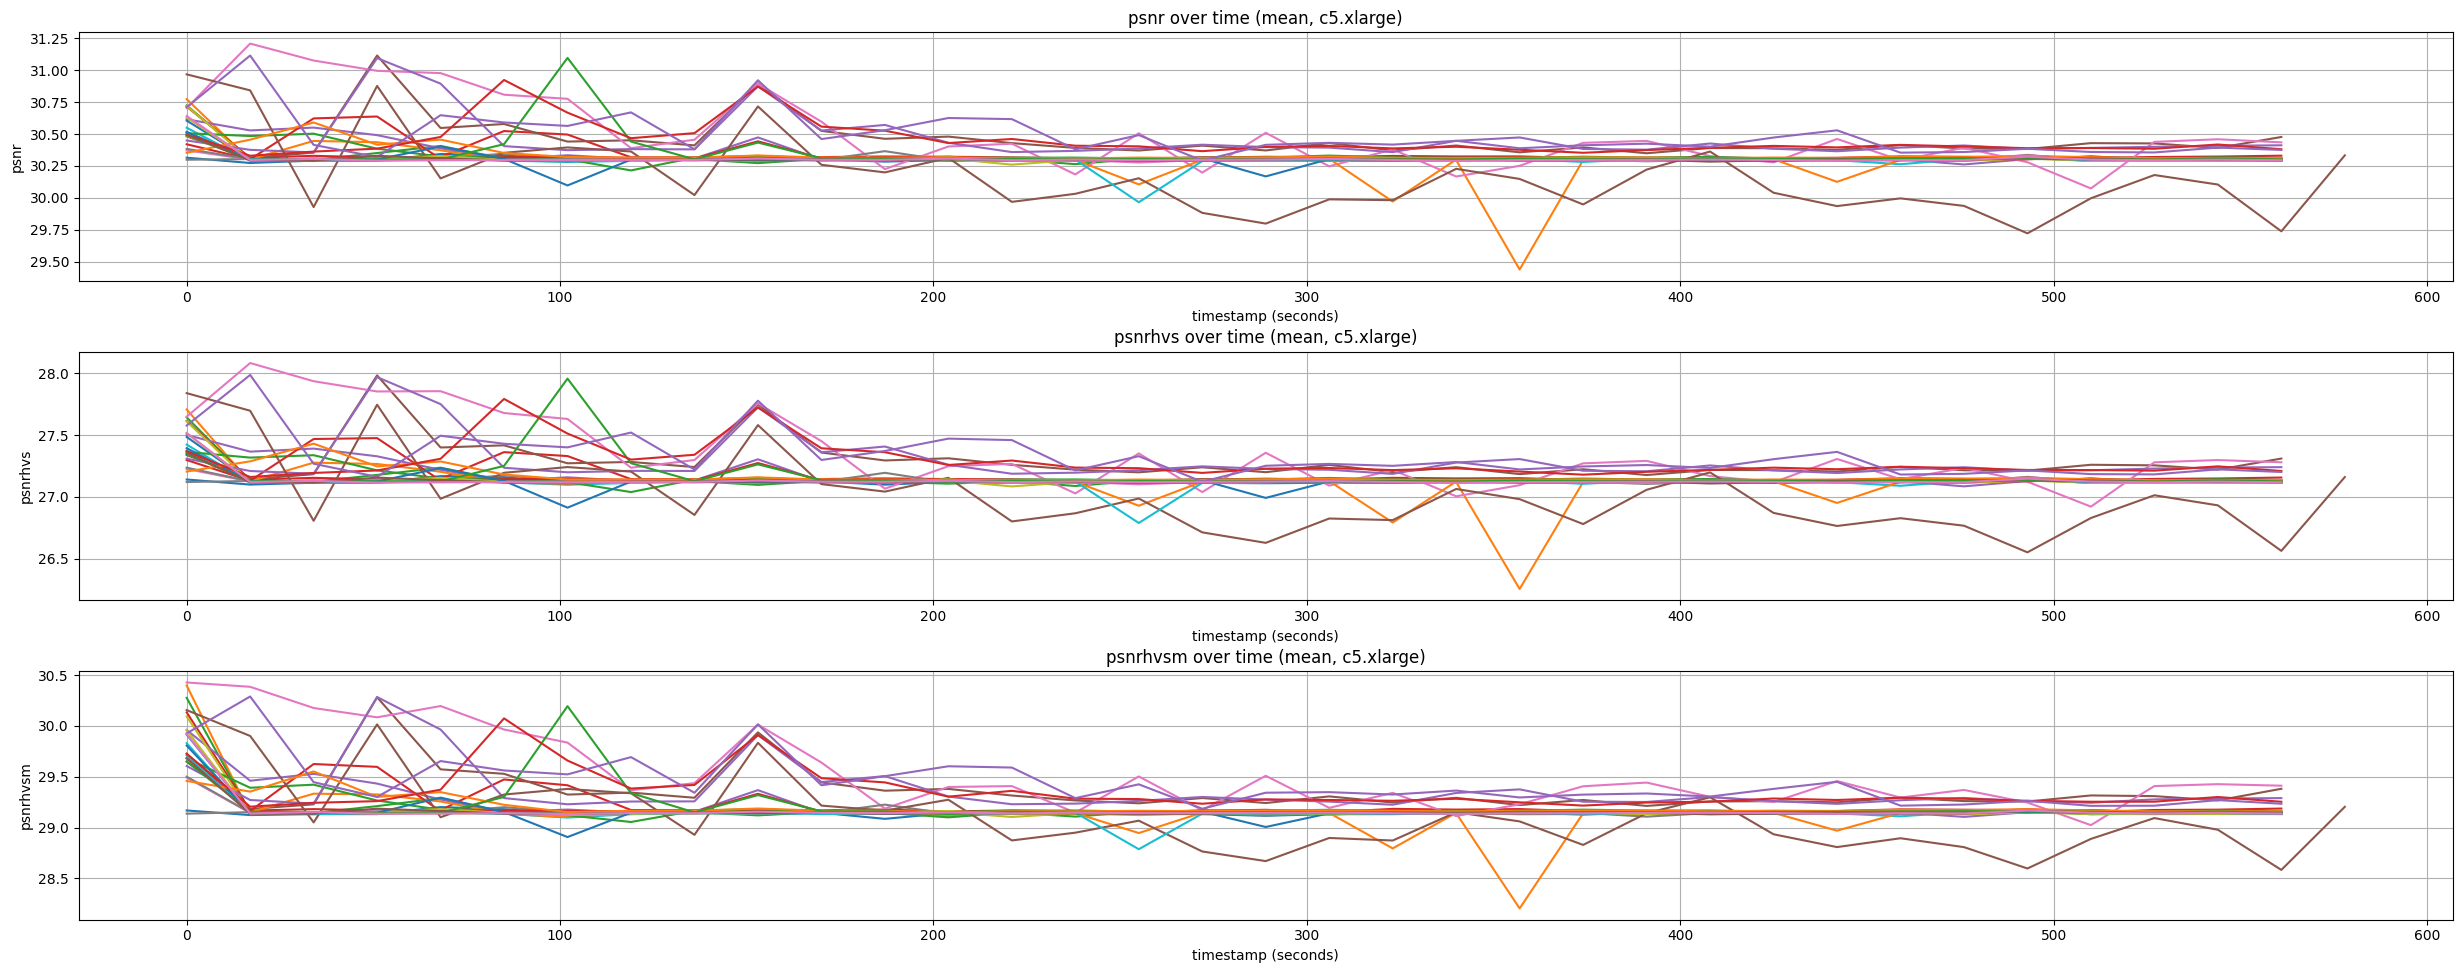

In [29]:
plt.rcParams['figure.figsize'] = [25, 10]
figure, axes = plt.subplots(3, 1)
figure.tight_layout(pad=3.0)
metrics = ["psnr", "psnrhvs", "psnrhvsm"]
max=1
instance_type="c5"
for idx, metric in enumerate(metrics):
        axe = axes[idx // max]
        axe.set_title(metric + " over time (mean, c5.xlarge)")
        axe.set_xlabel("timestamp (seconds)")
        axe.set_ylabel(metric)
        axe.grid()
        if not "psnr" in metric:
            axe.set_ylim(0, 1)
        for i, df_tmp in enumerate(df_list):
            if not df_tmp.empty:
                if instance_type in index_list[i]:
                    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
                    plot_name = index_list[i][28:]
                    if not df_mean.empty:
                        axe.plot(df_mean.index, df_mean[metric], label=plot_name)
#plt.legend(loc="upper left")
figure.savefig("images/c5xlarge_psnr.png")

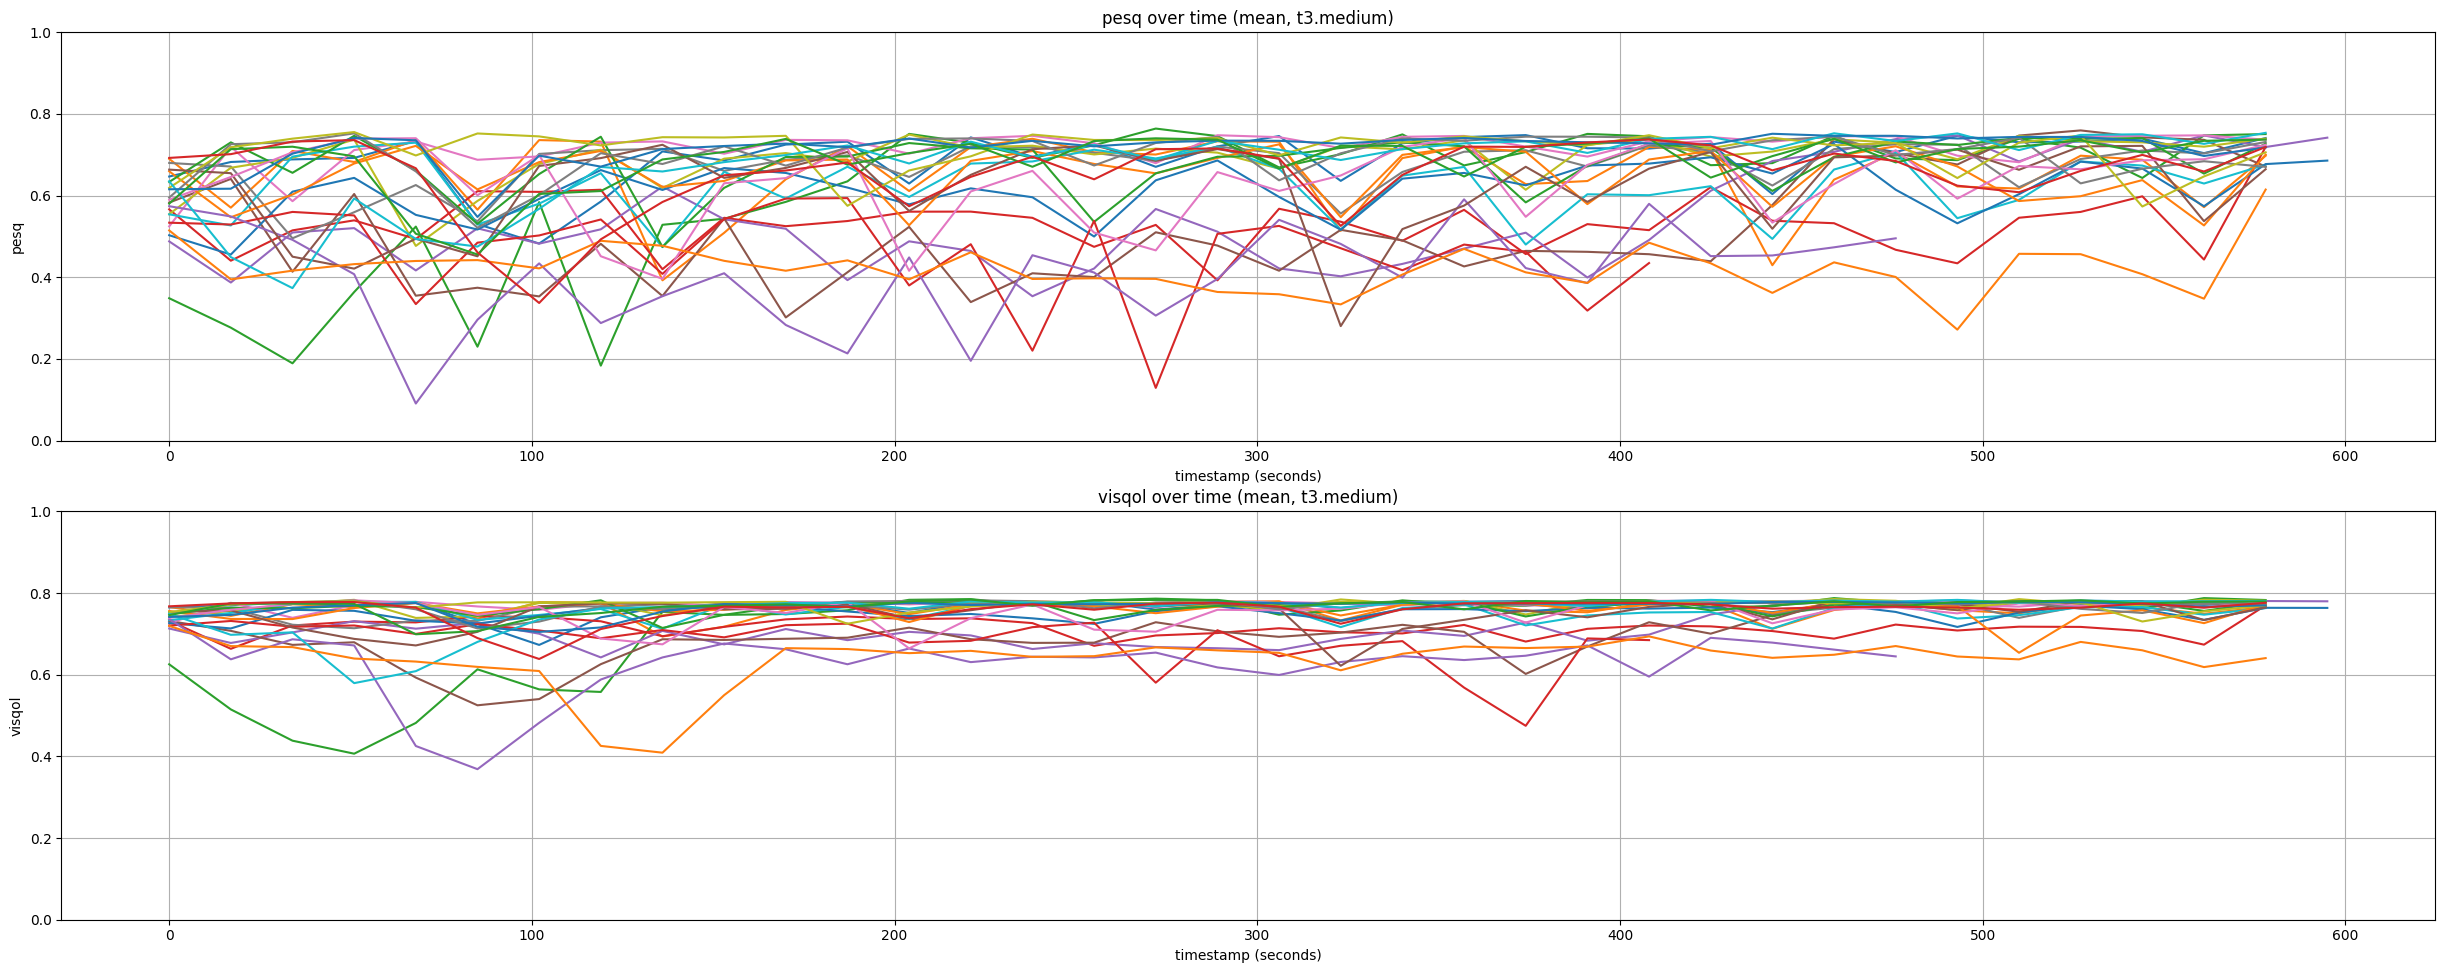

In [30]:
plt.rcParams['figure.figsize'] = [25, 10]
figure, axes = plt.subplots(2, 1)
figure.tight_layout(pad=3.0)
metrics = ["pesq", "visqol"]
max = 1
instance_type = "t3"

for idx, metric in enumerate(metrics):
        axe = axes[idx // max]
        axe.set_title(metric + " over time (mean, t3.medium)")
        axe.set_xlabel("timestamp (seconds)")
        axe.set_ylabel(metric)
        axe.grid()
        if not "psnr" in metric:
            axe.set_ylim(0, 1)
        for i, df_tmp in enumerate(df_list):
            if not df_tmp.empty:
                if instance_type in index_list[i]:
                    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
                    plot_name = index_list[i][28:]
                    if not df_mean.empty:
                        axe.plot(df_mean.index, df_mean[metric], label=plot_name)
figure.savefig("images/t3medium_audio.png")

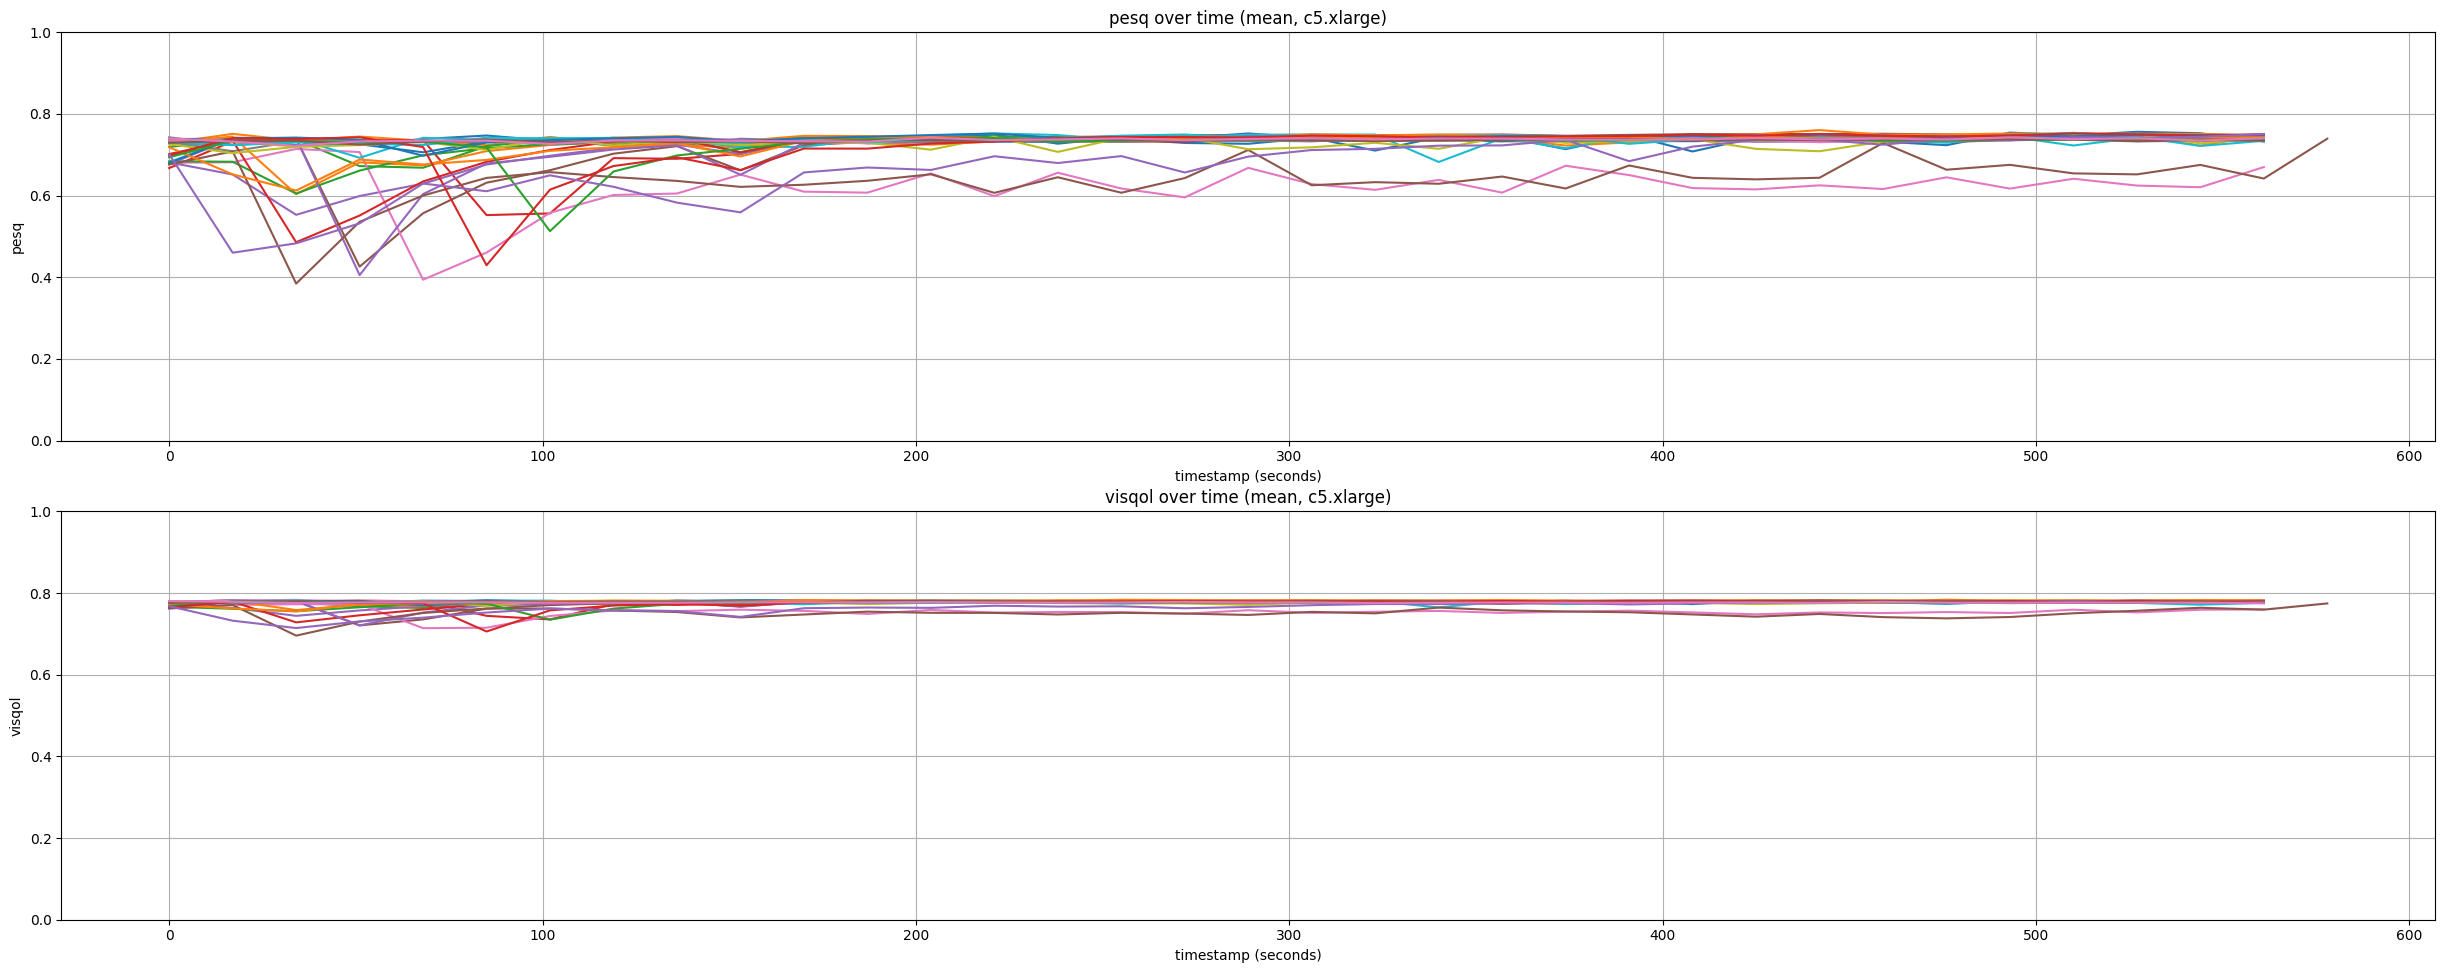

In [31]:
plt.rcParams['figure.figsize'] = [25, 10]
figure, axes = plt.subplots(2, 1)
figure.tight_layout(pad=3.0)
metrics = ["pesq", "visqol"]
max = 1
instance_type = "c5"

for idx, metric in enumerate(metrics):
        axe = axes[idx // max]
        axe.set_title(metric + " over time (mean, c5.xlarge)")
        axe.set_xlabel("timestamp (seconds)")
        axe.set_ylabel(metric)
        axe.grid()
        if not "psnr" in metric:
            axe.set_ylim(0, 1)
        for i, df_tmp in enumerate(df_list):
            if not df_tmp.empty:
                if instance_type in index_list[i]:
                    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
                    plot_name = index_list[i][28:]
                    if not df_mean.empty:
                        axe.plot(df_mean.index, df_mean[metric], label=plot_name)
figure.savefig("images/c5xlarge_audio.png")

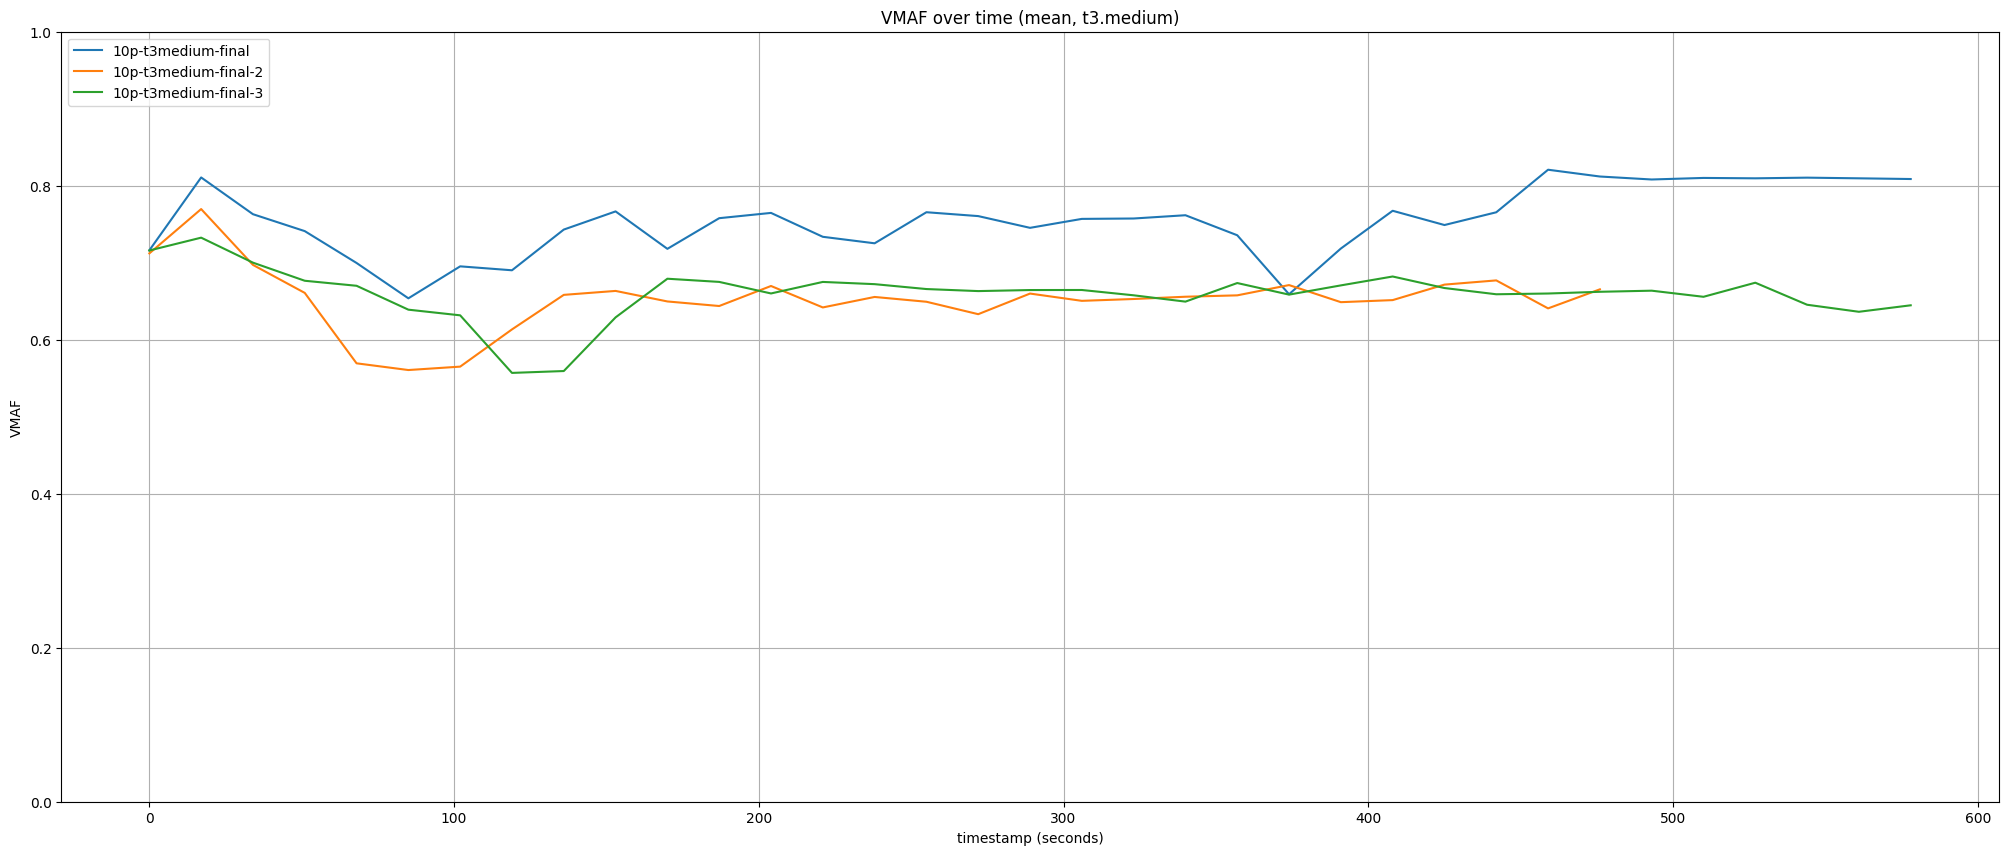

In [32]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if not df_tmp.empty:
        if "10p-t3medium" in index_list[i]:
            df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
            plot_name = index_list[i][28:]
            if not df_mean.empty:
                plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, t3.medium)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
plt.ylim(0, 1)
plt.legend(loc="upper left")

In [33]:
# INDIVIDUAL PLOTS PARAMETERS

# Index of index_list to use
index = 15
#If there is only one metric in display, choose which one
metric = "vmaf"

show_full_range = True

# Calculations
index_name = index_list[index]
metric_label = metric.upper()
qoe_metrics_normalized = ["vmaf", "msssim", "ssim", "vifp", "pesq", "visqol"]
qoe_metrics_not_normalized = ["psnr", "psnrhvs", "psnrhvsm"]

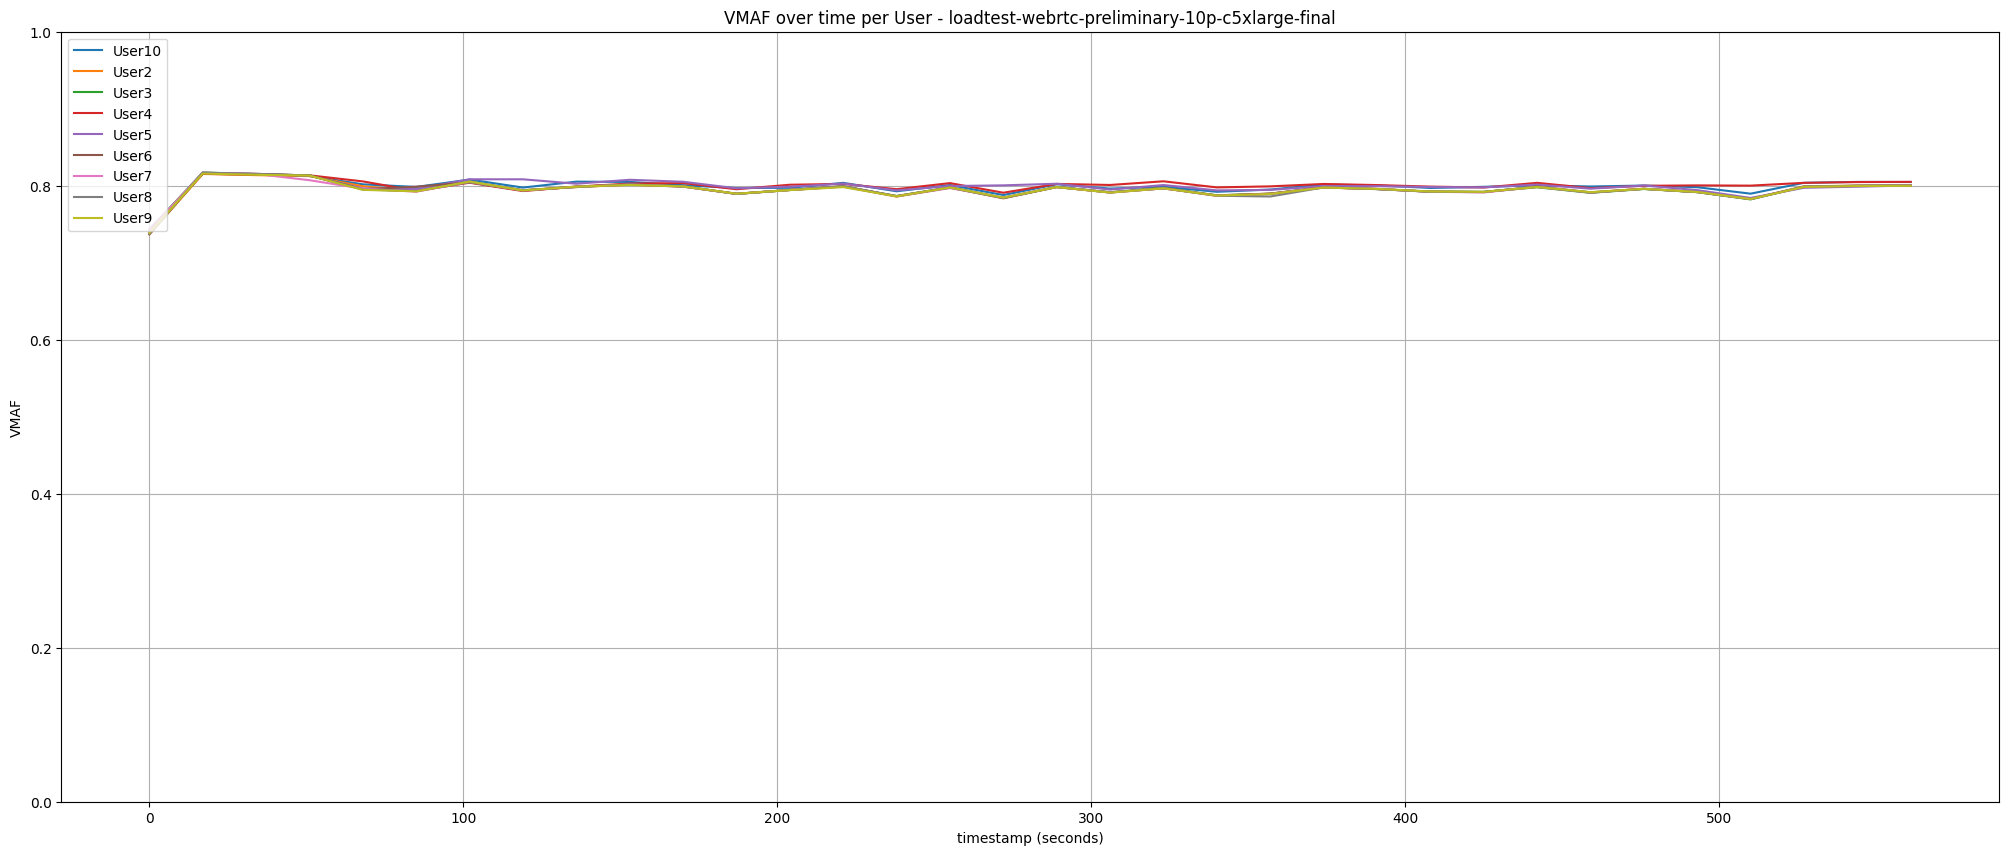

In [34]:
plt.rcParams['figure.figsize'] = [25, 10]

df_user = df_list[index]

for user in df_user.userFrom.unique():
    df_user1 = df_user[df_user.userFrom == user].groupby(["cut_index"]).mean(numeric_only=True)
    plt.plot(df_user1.index, df_user1[metric], label=user)

plt.title(metric_label + " over time per User - " + index_name)
plt.xlabel("timestamp (seconds)")
plt.ylabel(metric_label)
plt.legend(loc="upper left")
plt.grid()
if show_full_range:
    plt.ylim(0, 1)


ValueError: time data "2023-05-12 11:24:29+00:00" doesn't match format "%Y-%m-%d %H:%M:%S.%f%z", at position 638. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

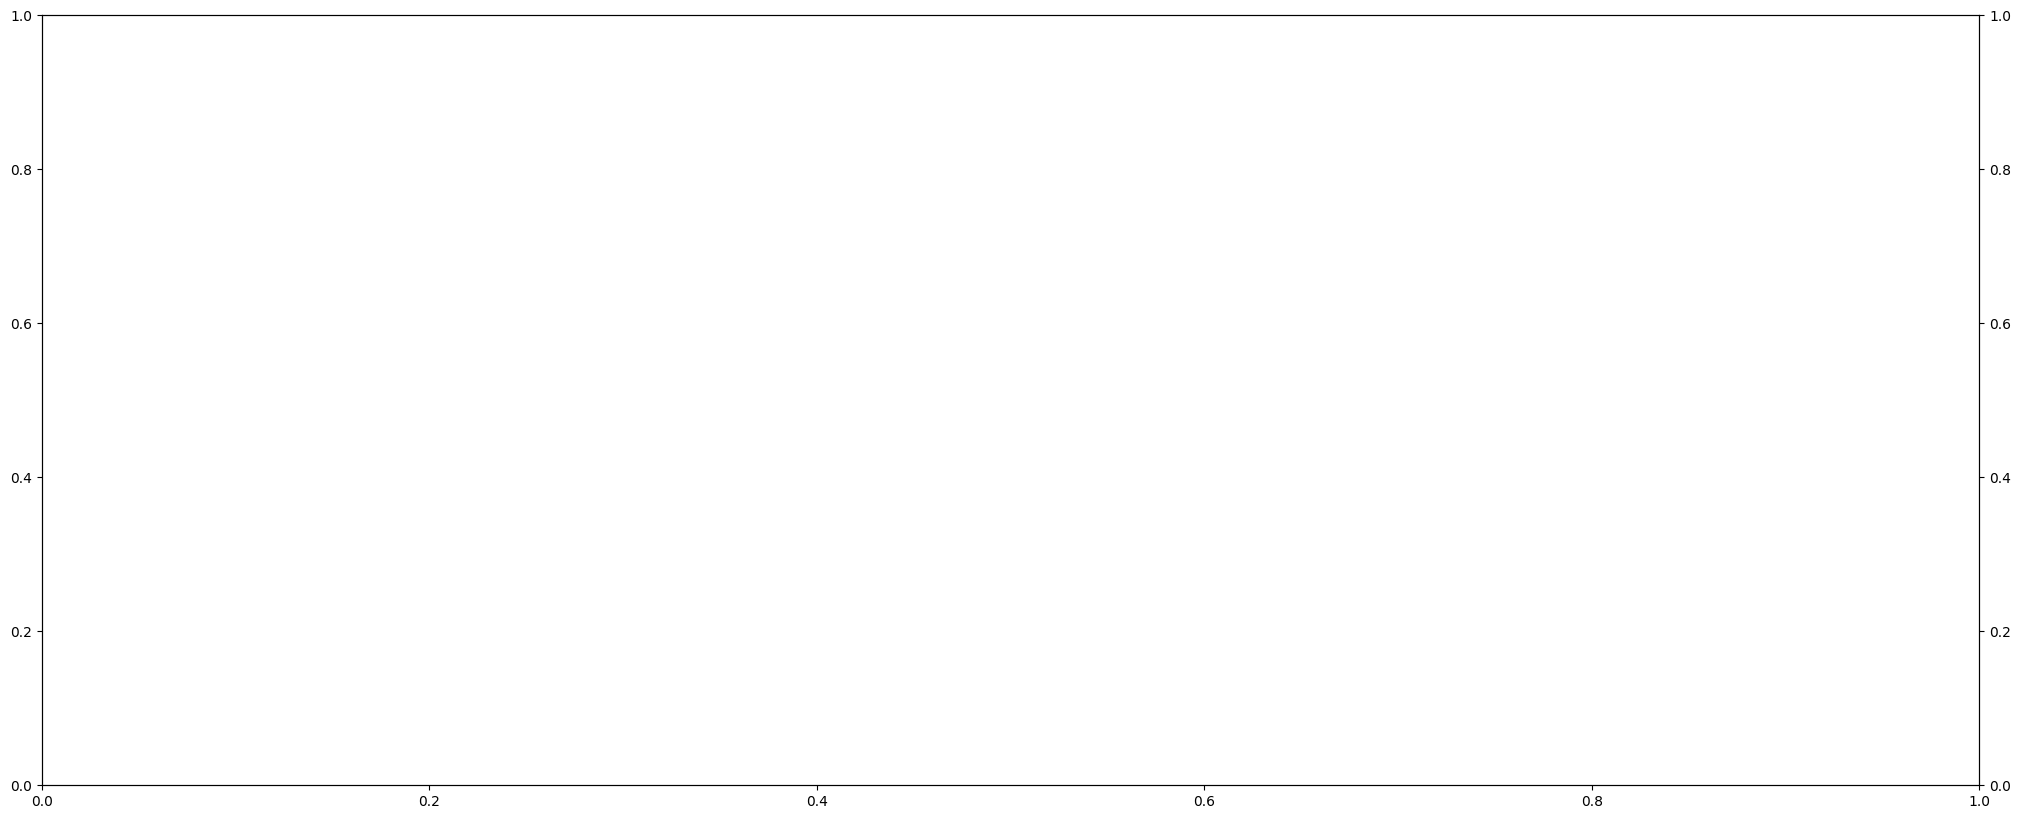

In [35]:
plt.rcParams['figure.figsize'] = [25, 10]
fig, ax = plt.subplots()

webrtc_stats_y = ax.twinx()

aggregation_map =  {"@timestamp": "first"}
for metric in qoe_metrics_normalized:
    aggregation_map[metric] = "mean"

df_tmp = df_list[index].groupby("cut_index").agg(aggregation_map)
df_node = pd.read_csv(f"dfs/{index_name}-browseremulator.csv")
df_node["@timestamp"] = pd.to_datetime(df_node["@timestamp"])
df = pd.concat([df_tmp, df_node])

df_stats_inbound = pd.read_csv(f"dfs/{index_name}-webrtc-stats-inbound.csv")
df_stats_outbound = pd.read_csv(f"dfs/{index_name}-webrtc-stats-outbound.csv")
df_stats_inbound["@timestamp"] = pd.to_datetime(df_stats_inbound["@timestamp"])
df_stats_outbound["@timestamp"] = pd.to_datetime(df_stats_outbound["@timestamp"])
df_stats_inbound = df_stats_inbound.groupby("@timestamp").mean()
df_stats_outbound = df_stats_outbound.groupby("@timestamp").mean()

qoe_zorder = 10
resource_zorder = 0

qoe_linewidth = 3
resource_linewidth = 1

legend_handles = []
for metric in qoe_metrics_normalized:
    legend_handles.append(ax.plot(df["@timestamp"], df[metric], label=metric,
             marker="o", zorder=qoe_zorder, lw=qoe_linewidth))
legend_handles.append(ax.plot(df["@timestamp"], df["cpu"].interpolate(method="linear"), "g",
         label="cpu", zorder=resource_zorder, lw=resource_linewidth))
legend_handles.append(ax.plot(df["@timestamp"], df["memory"].interpolate(method="linear"), "c",
         label="memory", zorder=resource_zorder, lw=resource_linewidth))


for column in df_stats_inbound.columns[1:]:
    # Maybe readd gpSum?
    if not "bytesSent" in column and not "packetsSent" in column and not "qpSum" in column and not "framesEncoded" in column:
        legend_handles.append(webrtc_stats_y.plot(df_stats_inbound.index, df_stats_inbound[column], label=column))

ax.set_title(f"QOE metric (normalized) over time (mean, worker data, {index_name})")
ax.set_xlabel("timestamp (day hour:minute)")
ax.set_ylabel("QOE metric (normalized), CPU %, Memory %")
webrtc_stats_y.set_ylabel("WebRTC stats")
ax.grid()
ax.legend(loc="upper left")
webrtc_stats_y.legend(loc="upper left")



In [ ]:

from scipy.stats import friedmanchisquare, wilcoxon, kruskal

vmaf_series_t3 = []
vmaf_series_c5 = []

for i, df_tmp in enumerate(df_list):
    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
    if (i % 2 == 0):
        vmaf_series_t3.append(df_mean["vmaf"][:34])
    else:
        vmaf_series_c5.append(df_mean["vmaf"][:34])

print("Friedman Kruskal tests with all t3.medium data:")
print(friedmanchisquare(*vmaf_series_t3))
print(kruskal(*vmaf_series_t3))
print()
print("Friedman Kruskal tests with all c5.xlarge data:")
print(friedmanchisquare(*vmaf_series_c5))
print(kruskal(*vmaf_series_c5))
print()
print("Wilcoxon Friedman Kruskal tests between 2p and 10p for t3.medium")
print(wilcoxon(vmaf_series_t3[0], vmaf_series_t3[-1]))
print(friedmanchisquare(vmaf_series_c5[0], vmaf_series_c5[-1], vmaf_series_t3[-2]))
print(kruskal(vmaf_series_c5[0], vmaf_series_c5[-1]))
print()
print("Wilcoxon Friedman Kruskal tests between 2p and 10p for c5.xlarge")
print(wilcoxon(vmaf_series_c5[0], vmaf_series_c5[-1]))
print(friedmanchisquare(vmaf_series_c5[0], vmaf_series_c5[-1], vmaf_series_c5[-2]))
print(kruskal(vmaf_series_c5[0], vmaf_series_c5[-1]))

KeyError: 'cut_index'